# Traffic Flow Prediction

### Part 1 Understand the Data 

**1.1 Data Introduction**<br>
The data is from the Caltrans Performance Measurement System (PeMS) database, http://pems.dot.ca.gov/. The traffic data are collected every 5 min from over 15000 individual detectors, which are deployed statewide in freeway systems across California.

**1.2 Data Preprocessing**

The collected data are aggregated 5-min interval each for each detector station. I plan to use the traffic flow data in the <u>weekdays</u> of the <u>July, August, September of the year 2020</u> for the experiments. 

July and August data as the training set, and September data as the testing set. 

For freeways with multiple detectors, the traffic data collected by different detectors are aggregated to get the average traffic flow of this freeway. 

**1.3 Data exploration code**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
import os
import gc
import logging
import time

In [10]:
July = pd.read_excel('./2020_07_ca/2000_pri_2020_07.xls','Flow') 

In [11]:
July
# Interstate 5, North
# timestamp means every 5 minutes interval
# other cols mean different station detectors
# This list is sorted in the direction of travel
# Each of row means a timestamp column followed 
# by columns for each station. Stations are ordered in the direction of travel.

,Timestamp,762347,716896,716899,716900,762353,775012,718358,769625,718081,...,716921,715933,716923,763975,716925,715938,716929,764435,715944,718086
0,07/01/2020 00:00,145.0,145.0,145.0,145.0,145.0,178.0,145.0,100,50.0,...,82,34.0,81.0,113.0,113.0,76,64.0,89.0,77.0,70.0
1,07/01/2020 00:05,142.0,142.0,142.0,142.0,142.0,171.0,142.0,119,77.0,...,89,58.0,99.0,108.0,95.0,64,68.0,82.0,68.0,58.0
2,07/01/2020 00:10,141.0,141.0,141.0,141.0,141.0,169.0,141.0,135,86.0,...,101,64.0,107.0,102.0,110.0,64,47.0,75.0,59.0,49.0
3,07/01/2020 00:15,135.0,135.0,136.0,136.0,135.0,165.0,136.0,127,75.0,...,86,70.0,95.0,112.0,124.0,84,93.0,101.0,98.0,85.0
4,07/01/2020 00:20,130.0,130.0,130.0,130.0,130.0,158.0,130.0,142,82.0,...,129,105.0,134.0,120.0,137.0,111,90.0,77.0,89.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12374,07/31/2020 23:35,262.0,262.0,262.0,262.0,262.0,320.0,262.0,163,155.0,...,142,170.0,158.0,262.0,176.0,207,202.0,198.0,192.0,176.0
12375,07/31/2020 23:40,254.0,254.0,255.0,255.0,254.0,316.0,255.0,138,140.0,...,164,204.0,184.0,254.0,206.0,199,187.0,180.0,172.0,160.0
12376,07/31/2020 23:45,250.0,250.0,248.0,248.0,250.0,306.0,248.0,126,119.0,...,158,183.0,174.0,235.0,192.0,218,200.0,246.0,228.0,204.0
12377,07/31/2020 23:50,238.0,238.0,238.0,238.0,238.0,298.0,238.0,159,148.0,...,156,197.0,184.0,238.0,196.0,195,195.0,144.0,183.0,163.0


In [22]:
# select columns used to calculate mean
need_col = list(July.columns)[1:]
temp = July[need_col]
# add new avg col
July['avg'] = temp.mean(axis=1)

In [20]:
July

,Timestamp,762347,716896,716899,716900,762353,775012,718358,769625,718081,...,715933,716923,763975,716925,715938,716929,764435,715944,718086,avg
0,07/01/2020 00:00,145.0,145.0,145.0,145.0,145.0,178.0,145.0,100,50.0,...,34.0,81.0,113.0,113.0,76,64.0,89.0,77.0,70.0,97.703704
1,07/01/2020 00:05,142.0,142.0,142.0,142.0,142.0,171.0,142.0,119,77.0,...,58.0,99.0,108.0,95.0,64,68.0,82.0,68.0,58.0,99.333333
2,07/01/2020 00:10,141.0,141.0,141.0,141.0,141.0,169.0,141.0,135,86.0,...,64.0,107.0,102.0,110.0,64,47.0,75.0,59.0,49.0,105.518519
3,07/01/2020 00:15,135.0,135.0,136.0,136.0,135.0,165.0,136.0,127,75.0,...,70.0,95.0,112.0,124.0,84,93.0,101.0,98.0,85.0,106.370370
4,07/01/2020 00:20,130.0,130.0,130.0,130.0,130.0,158.0,130.0,142,82.0,...,105.0,134.0,120.0,137.0,111,90.0,77.0,89.0,76.0,118.481481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12374,07/31/2020 23:35,262.0,262.0,262.0,262.0,262.0,320.0,262.0,163,155.0,...,170.0,158.0,262.0,176.0,207,202.0,198.0,192.0,176.0,207.222222
12375,07/31/2020 23:40,254.0,254.0,255.0,255.0,254.0,316.0,255.0,138,140.0,...,204.0,184.0,254.0,206.0,199,187.0,180.0,172.0,160.0,209.481481
12376,07/31/2020 23:45,250.0,250.0,248.0,248.0,250.0,306.0,248.0,126,119.0,...,183.0,174.0,235.0,192.0,218,200.0,246.0,228.0,204.0,206.259259
12377,07/31/2020 23:50,238.0,238.0,238.0,238.0,238.0,298.0,238.0,159,148.0,...,197.0,184.0,238.0,196.0,195,195.0,144.0,183.0,163.0,198.148148


In [37]:
# change index for better using
July_copy = July
July_copy.index = pd.to_datetime(July["Timestamp"], format="%m/%d/%Y %H:%M")

In [60]:
July_copy

,Timestamp,762347,716896,716899,716900,762353,775012,718358,769625,718081,...,715933,716923,763975,716925,715938,716929,764435,715944,718086,avg
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-07-01 00:00:00,07/01/2020 00:00,145.0,145.0,145.0,145.0,145.0,178.0,145.0,100,50.0,...,34.0,81.0,113.0,113.0,76,64.0,89.0,77.0,70.0,97.703704
2020-07-01 00:05:00,07/01/2020 00:05,142.0,142.0,142.0,142.0,142.0,171.0,142.0,119,77.0,...,58.0,99.0,108.0,95.0,64,68.0,82.0,68.0,58.0,99.333333
2020-07-01 00:10:00,07/01/2020 00:10,141.0,141.0,141.0,141.0,141.0,169.0,141.0,135,86.0,...,64.0,107.0,102.0,110.0,64,47.0,75.0,59.0,49.0,105.518519
2020-07-01 00:15:00,07/01/2020 00:15,135.0,135.0,136.0,136.0,135.0,165.0,136.0,127,75.0,...,70.0,95.0,112.0,124.0,84,93.0,101.0,98.0,85.0,106.370370
2020-07-01 00:20:00,07/01/2020 00:20,130.0,130.0,130.0,130.0,130.0,158.0,130.0,142,82.0,...,105.0,134.0,120.0,137.0,111,90.0,77.0,89.0,76.0,118.481481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31 23:35:00,07/31/2020 23:35,262.0,262.0,262.0,262.0,262.0,320.0,262.0,163,155.0,...,170.0,158.0,262.0,176.0,207,202.0,198.0,192.0,176.0,207.222222
2020-07-31 23:40:00,07/31/2020 23:40,254.0,254.0,255.0,255.0,254.0,316.0,255.0,138,140.0,...,204.0,184.0,254.0,206.0,199,187.0,180.0,172.0,160.0,209.481481
2020-07-31 23:45:00,07/31/2020 23:45,250.0,250.0,248.0,248.0,250.0,306.0,248.0,126,119.0,...,183.0,174.0,235.0,192.0,218,200.0,246.0,228.0,204.0,206.259259


In [66]:
# create new df for each day
Wed = July_copy.loc['2020-07-01']
Thu = July_copy.loc['2020-07-02']
Fri = July_copy.loc['2020-07-03']
Sat = July_copy.loc['2020-07-04']
Sun = July_copy.loc['2020-07-05']
Mon = July_copy.loc['2020-07-06']
Tue = July_copy.loc['2020-07-07']
day_lst =[Mon, Tue, Wed, Thu, Fri, Sat, Sun]
name_lst =['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

Mon


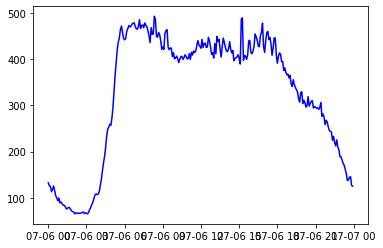

Tue


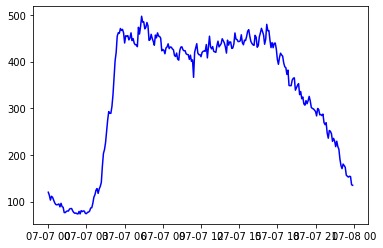

Wed


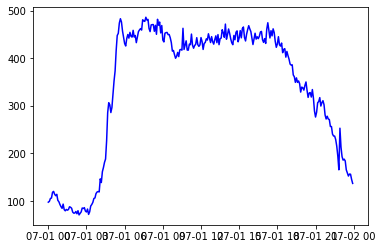

Thu


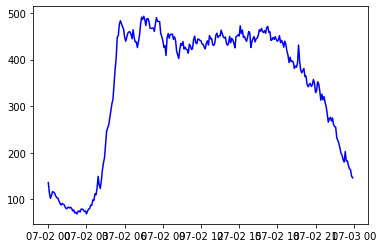

Fri


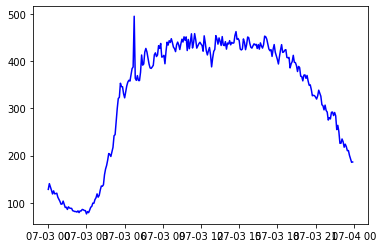

Sat


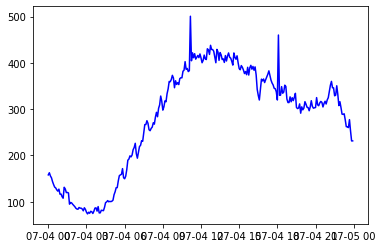

Sun


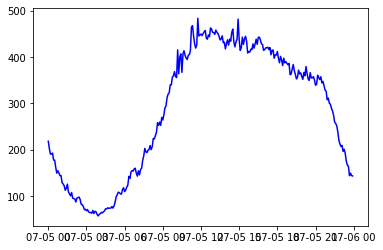

In [59]:
# plot trend for each day
for day,name in zip(day_lst, name_lst):
    x = day.index
    y = day['avg']
    print(name)
    plt.plot(x,y,color = 'b')
    plt.show()

In [67]:
week1 = July_copy.loc['2020-07-06':'2020-07-12']
week2 = July_copy.loc['2020-07-13':'2020-07-19']
week3 = July_copy.loc['2020-07-20':'2020-07-26']
week_lst =[week1, week2, week3]
name_w_lst =['week1', 'week2', 'week3']

week1


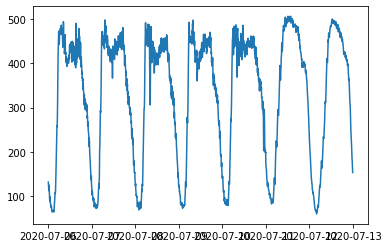

week2


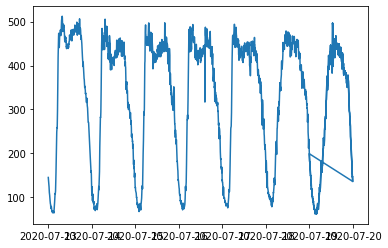

week3


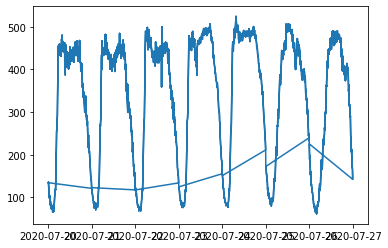

In [75]:
# plot trend for each week
for day,name in zip(week_lst, name_w_lst):
    x = day.index
    y = day['avg']
    print(name)
    plt.plot(x,y)
    plt.show()

week1


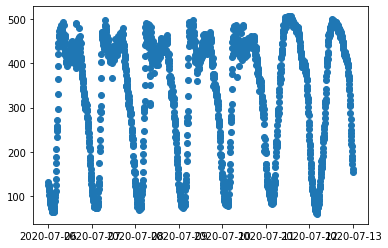

week2


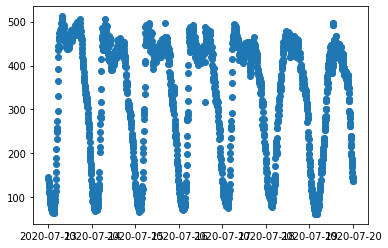

week3


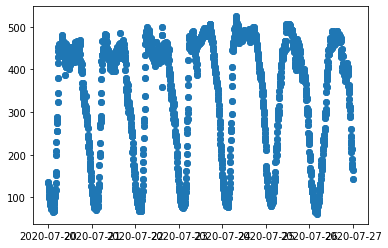

In [76]:
# plot trend for each week
for day,name in zip(week_lst, name_w_lst):
    x = day.index
    y = day['avg']
    print(name)
    #plt.plot(x,y)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot_date(x, y)
    plt.show()

#### Train data preprocessing

In [ ]:
# focus on lanes
# compare diff patterns on diff lanes
# consider summer holiday, change to 2,3,4
# built first model

In [31]:
month = 2
fi = 'corridor_2000_2020_0'
file = 'c2000_pri_2020_0'
print('{}{}/{}{}.xls'.format(fi, month, file, month))

corridor_2000_2020_02/c2000_pri_2020_02.xls


In [32]:
Train_df_merge = data_read('corridor_2000_2020_0', 'c2000_pri_2020_0')

In [54]:
Train_df_merge

,Timestamp,Avg
Timestamp,,
2020-02-01 00:00:00,02/01/2020 00:00,228.307692
2020-02-01 00:05:00,02/01/2020 00:05,227.500000
2020-02-01 00:10:00,02/01/2020 00:10,204.346154
2020-02-01 00:15:00,02/01/2020 00:15,207.192308
2020-02-01 00:20:00,02/01/2020 00:20,199.846154
...,...,...
2020-03-31 23:35:00,03/31/2020 23:35,148.615385
2020-03-31 23:40:00,03/31/2020 23:40,150.884615
2020-03-31 23:45:00,03/31/2020 23:45,136.769231


In [34]:
Train_df_merge['Avg'].min()

57.0

In [35]:
Train_df_merge['Avg'].max()

543.0

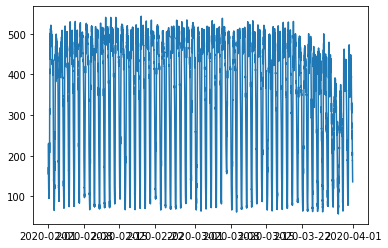

In [37]:

x = Train_df_merge.index
y = Train_df_merge['Avg']
plt.plot(x,y)
plt.show()

In [44]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(Train_df_merge['Avg'].values.reshape(-1, 1))

In [48]:
flow1 = scaler.transform(Train_df_merge['Avg'].values.reshape(-1, 1)).reshape(1, -1)

In [55]:
flow1

array([[0.35248496, 0.35082305, 0.30318139, ..., 0.16413422, 0.1736309 ,
        0.16223488]])

In [83]:
flow1.shape

(1, 17268)

In [51]:
a = np.squeeze(flow1)

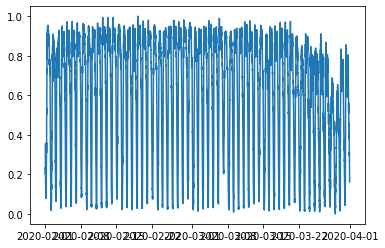

In [53]:
x = Train_df_merge.index
y = a
plt.plot(x,y)
plt.show()

#### Model GRU

In [58]:
import sys
import warnings
import argparse
from keras.models import Model
from keras.callbacks import EarlyStopping

In [59]:
"""
Data Read in
"""
def data_read(folder, file, state):
    """
    folder: folder name, string
    file: file name, string
    state: read in trin/test data csv
    """
    if state == 'train':
        months = [2, 3]
    else:
        months = [4]
    file_merge = []
    for month in months:
        #print(month)
        df = pd.read_excel('{}{}/{}{}.xls'.format(folder, month, file, month),'Flow') 
        need_col = list(df.columns)[1:]
        temp = df[need_col]
        # add new avg col
        df['Avg'] = temp.mean(axis=1)
        use_df = df[['Timestamp', 'Avg']]
        file_merge.append(use_df)
    Train_df_merge = pd.concat(file_merge, axis=0, ignore_index=True)
    Train_df_merge.index = pd.to_datetime(Train_df_merge["Timestamp"], format="%m/%d/%Y %H:%M")
    return Train_df_merge

In [136]:
"""
Processing the data
"""
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def process_data(train, test, lags):
    """Process data
    Reshape and split train\test data.
    # Arguments
        train: dataframe of train file.
        test: df of test file.
        lags: integer, time lag.
    # Returns
        X_train: ndarray.
        y_train: ndarray.
        X_test: ndarray.
        y_test: ndarray.
        scaler: StandardScaler.
    """
    attr = 'Avg'

    scaler = MinMaxScaler(feature_range=(0, 1)).fit(train[attr].values.reshape(-1, 1))
    # 1d array
    flow1 = scaler.transform(train[attr].values.reshape(-1, 1)).reshape(1, -1)[0]
    print('flow1',flow1.shape)
    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(test[attr].values.reshape(-1, 1))
    # 1d array
    flow2 = scaler.transform(test[attr].values.reshape(-1, 1)).reshape(1, -1)[0]
    print('flow2',flow2.shape)
    
    train_lst, test_lst = [], []
    for i in range(lags, len(flow1)):
        train_lst.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test_lst.append(flow2[i - lags: i + 1])

    train = np.array(train_lst)
    test = np.array(test_lst)
    np.random.shuffle(train_lst)

    X_train = train[:, :-1]
    print('x_train',X_train.shape)
    y_train = train[:, -1]
    print('y_train',y_train.shape)
    X_test = test[:, :-1]
    print('x_test',X_test.shape)
    y_test = test[:, -1]
    print('y_test',y_test.shape)

    return X_train, y_train, X_test, y_test, scaler

In [137]:
#samples,12
train = data_read('corridor_2000_2020_0', 'c2000_pri_2020_0', 'train')
test = data_read('corridor_2000_2020_0', 'c2000_pri_2020_0', 'test')
process_data(train, test, 12)

flow1 (17268,)
flow2 (8639,)
x_train (17256, 12)
y_train (17256,)
x_test (8627, 12)
y_test (8627,)


(array([[0.35248496, 0.35082305, 0.30318139, ..., 0.20829376, 0.19966762,
         0.21217157],
        [0.35082305, 0.30318139, 0.30903767, ..., 0.19966762, 0.21217157,
         0.23646724],
        [0.30318139, 0.30903767, 0.29392213, ..., 0.21217157, 0.23646724,
         0.20164609],
        ...,
        [0.26946819, 0.27018044, 0.26384932, ..., 0.16706236, 0.18850902,
         0.19317822],
        [0.27018044, 0.26384932, 0.24525166, ..., 0.18850902, 0.19317822,
         0.16413422],
        [0.26384932, 0.24525166, 0.23757518, ..., 0.19317822, 0.16413422,
         0.1736309 ]]),
 array([0.23646724, 0.20164609, 0.18945869, ..., 0.16413422, 0.1736309 ,
        0.16223488]),
 array([[0.13775899, 0.12786469, 0.12871036, ..., 0.09792812, 0.08744186,
         0.08744186],
        [0.12786469, 0.12871036, 0.13082452, ..., 0.08744186, 0.08744186,
         0.08016913],
        [0.12871036, 0.13082452, 0.13437632, ..., 0.08744186, 0.08016913,
         0.07044397],
        ...,
        [0.29

In [61]:
"""
Defination of NN model
"""
from keras.layers import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential

def get_gru(units):
    """GRU(Gated Recurrent Unit)
    Build GRU Model.
    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(GRU(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(GRU(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model

In [143]:
m = get_gru([12, 64, 64, 1])
print(m.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, 12, 64)            12864     
_________________________________________________________________
gru_17 (GRU)                 (None, 64)                24960     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________
None


In [115]:
def train_model(model, X_train, y_train, name, config):
    """train
    train a single model.
    # Arguments
        model: Model, NN model to train.
        X_train: ndarray(number, lags), Input data for train.
        y_train: ndarray(number, ), result data for train.
        name: String, name of model.
        config: Dict, parameter for train.
    """

    model.compile(loss="mse", optimizer="rmsprop", metrics=['mape'])
    # early = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
    hist = model.fit(
        X_train, y_train,
        batch_size=config["batch"],
        epochs=config["epochs"],
        validation_split=0.05)

    model.save('./model' + name + '——.h5')
    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv('./model' + name + ' loss.csv', encoding='utf-8', index=False)

In [116]:
def main(arg,train,test):

    lag = 12
    config = {"batch": 256, "epochs": 150}
    X_train, y_train, _, _, _ = process_data(train, test, lag)

    if arg == 'gru':
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        m = get_gru([12, 64, 64, 1])
        train_model(m, X_train, y_train, arg, config)


if __name__ == '__main__':
    train = data_read('corridor_2000_2020_0', 'c2000_pri_2020_0', 'train')
    test = data_read('corridor_2000_2020_0', 'c2000_pri_2020_0', 'test')
    main('gru',train,test)

Epoch 1/150
65/65 [==============================] - 2s 31ms/step - loss: 0.0146 - mape: 47.8331 - val_loss: 0.0045 - val_mape: 107535.4609
Epoch 2/150
65/65 [==============================] - 2s 24ms/step - loss: 0.0029 - mape: 19.3883 - val_loss: 0.0024 - val_mape: 106818.0000
Epoch 3/150
65/65 [==============================] - 1s 23ms/step - loss: 0.0019 - mape: 16.0213 - val_loss: 0.0012 - val_mape: 81662.5234
Epoch 4/150
65/65 [==============================] - 2s 23ms/step - loss: 0.0016 - mape: 13.4833 - val_loss: 0.0038 - val_mape: 36631.1250
Epoch 5/150
65/65 [==============================] - 1s 23ms/step - loss: 0.0014 - mape: 12.3728 - val_loss: 0.0034 - val_mape: 17224.5801
Epoch 6/150
65/65 [==============================] - 1s 23ms/step - loss: 0.0013 - mape: 11.4596 - val_loss: 0.0026 - val_mape: 31537.3535
Epoch 7/150
65/65 [==============================] - 1s 23ms/step - loss: 0.0012 - mape: 11.0043 - val_loss: 0.0031 - val_mape: 74178.0312
Epoch 8/150
65/65 [======

Epoch 58/150
65/65 [==============================] - 1s 23ms/step - loss: 5.6229e-04 - mape: 6.8617 - val_loss: 8.0762e-04 - val_mape: 16762.1172
Epoch 59/150
65/65 [==============================] - 1s 23ms/step - loss: 5.5056e-04 - mape: 6.6488 - val_loss: 6.3106e-04 - val_mape: 25580.2227
Epoch 60/150
65/65 [==============================] - 2s 23ms/step - loss: 5.4984e-04 - mape: 6.6964 - val_loss: 7.5132e-04 - val_mape: 22297.2812
Epoch 61/150
65/65 [==============================] - 2s 23ms/step - loss: 5.5178e-04 - mape: 6.4780 - val_loss: 0.0016 - val_mape: 13693.9707
Epoch 62/150
65/65 [==============================] - 2s 24ms/step - loss: 5.5996e-04 - mape: 6.7622 - val_loss: 0.0016 - val_mape: 83665.8203
Epoch 63/150
65/65 [==============================] - 2s 24ms/step - loss: 5.5785e-04 - mape: 6.7594 - val_loss: 0.0011 - val_mape: 21522.3184
Epoch 64/150
65/65 [==============================] - 2s 25ms/step - loss: 5.4360e-04 - mape: 6.5730 - val_loss: 7.9857e-04 - val_

Epoch 114/150
65/65 [==============================] - 2s 23ms/step - loss: 4.8160e-04 - mape: 6.1340 - val_loss: 5.0407e-04 - val_mape: 28567.9395
Epoch 115/150
65/65 [==============================] - 2s 25ms/step - loss: 4.8329e-04 - mape: 6.1561 - val_loss: 6.0437e-04 - val_mape: 21285.4375
Epoch 116/150
65/65 [==============================] - 2s 24ms/step - loss: 4.7589e-04 - mape: 6.0051 - val_loss: 5.7683e-04 - val_mape: 31091.1152
Epoch 117/150
65/65 [==============================] - 2s 24ms/step - loss: 4.8001e-04 - mape: 6.1134 - val_loss: 5.0952e-04 - val_mape: 33578.7461
Epoch 118/150
65/65 [==============================] - 1s 23ms/step - loss: 4.7692e-04 - mape: 6.0973 - val_loss: 8.2868e-04 - val_mape: 30820.4844
Epoch 119/150
65/65 [==============================] - 1s 23ms/step - loss: 4.7632e-04 - mape: 5.8790 - val_loss: 5.7097e-04 - val_mape: 25779.4766
Epoch 120/150
65/65 [==============================] - 2s 24ms/step - loss: 4.7533e-04 - mape: 6.0721 - val_loss

In [71]:
import math
import warnings
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt

In [77]:
def MAPE(y_true, y_pred):
    """Mean Absolute Percentage Error
    Calculate the mape.
    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    # Returns
        mape: Double, result data for train.
    """

    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

    num = len(y_pred)
    sums = 0

    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp

    mape = sums * (100 / num)

    return mape

In [72]:
def eva_regress(y_true, y_pred):
    """Evaluation
    evaluate the predicted result.
    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    """

    mape = MAPE(y_true, y_pred)
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance_score:%f' % vs)
    print('mape:%f%%' % mape)
    print('mae:%f' % mae)
    print('mse:%f' % mse)
    print('rmse:%f' % math.sqrt(mse))
    print('r2:%f' % r2)

In [117]:
def plot_results(y_true, y_preds, names):
    """Plot
    Plot the true data and predicted data.
    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
        names: List, Method names.
    """
    d = '2020-4-1 00:00'
    x = pd.date_range(d, periods=288, freq='5min')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, y_true, label='True Data')
    #for name, y_pred in zip(names, y_preds):
    ax.plot(x, y_preds, label='GRU')

    plt.legend()
    plt.grid(True)
    plt.xlabel('Time of Day')
    plt.ylabel('Flow')

    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    plt.show()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
GRU
explained_variance_score:0.988559
mape:5.414422%
mae:10.767868
mse:188.997228
rmse:13.747626
r2:0.988274
y (288,)


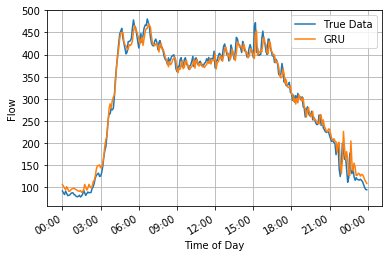

In [124]:
def main(train,test):
    gru = load_model('modelgru.h5')
    models = [gru]
    names = ['GRU']
    lag = 12
    
    _, _, X_test, y_test, scaler = process_data(train, test, lag)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

    y_preds = []
    for name, model in zip(names, models):
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        file = name + '.png'
        plot_model(model, to_file=file, show_shapes=True)
        predicted = model.predict(X_test)
        predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]
        y_preds.append(predicted[:288])
        print(name)
        eva_regress(y_test, predicted)
    y_test = y_test[: 288].reshape(288)
    y_preds = np.array(y_preds)
    y_preds = y_preds.reshape(288)
    print('y',y_test.shape)
    plot_results(y_test, y_preds, names)


if __name__ == '__main__':
    train = data_read('corridor_2000_2020_0', 'c2000_pri_2020_0', 'train')
    test = data_read('corridor_2000_2020_0', 'c2000_pri_2020_0', 'test')
    main(train,test)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
GRU
explained_variance_score:0.988559
mape:5.414422%
mae:10.767868
mse:188.997228
rmse:13.747626
r2:0.988274


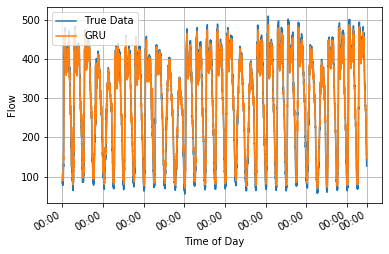

In [106]:
def main(train,test):
    gru = load_model('modelgru.h5')
    models = [gru]
    names = ['GRU']
    lag = 12
    
    _, _, X_test, y_test, scaler = process_data(train, test, lag)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

    y_preds = []
    for name, model in zip(names, models):
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        file = name + '.png'
        plot_model(model, to_file=file, show_shapes=True)
        predicted = model.predict(X_test)
        predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]
        y_preds.append(predicted)
        print(name)
        eva_regress(y_test, predicted)
    
    plot_results(y_test, y_preds, names)


if __name__ == '__main__':
    train = data_read('corridor_2000_2020_0', 'c2000_pri_2020_0', 'train')
    test = data_read('corridor_2000_2020_0', 'c2000_pri_2020_0', 'test')
    main(train,test)

flow1 (17268,)
flow2 (8639,)
x_train (17256, 12)
y_train (17256,)
x_test (8627, 12)
y_test (8627,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
GRU
explained_variance_score:-0.317007
mape:69.736351%
mae:124.764959
mse:21122.935357
rmse:145.337316
r2:-0.324207


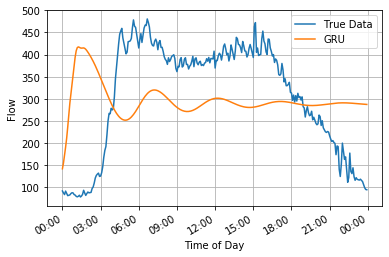

In [139]:
"""
Recursive self Predict
"""
from collections import defaultdict

def main(train,test):
    gru = load_model('modelgru.h5')
    models = [gru]
    names = ['GRU']
    lag = 12
    
    x_prior, _, X_test, y_test, scaler = process_data(train, test, lag)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

    y_preds = []
    for name, model in zip(names, models):
        x_prior = np.reshape(x_prior[-1,:], (1, 12, 1))
        file = name + '.png'
        plot_model(model, to_file=file, show_shapes=True) 
        
        for i in range(288):
            predicted = model.predict(x_prior)
            x_prior = x_prior[0, 1:, :]
            x_prior = np.append(x_prior, predicted, axis=0)
            x_prior = np.reshape(x_prior, (1, 12, 1))
            predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]
            y_preds.append(predicted)
        print(name)
        eva_regress(y_test[: 288], y_preds)
    #print('pre', y_preds)
    plot_results(y_test[: 288], y_preds, names)


if __name__ == '__main__':
    train = data_read('corridor_2000_2020_0', 'c2000_pri_2020_0', 'train')
    test = data_read('corridor_2000_2020_0', 'c2000_pri_2020_0', 'test')
    main(train,test)